In [350]:
import functions 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

import os 
import glob

import seaborn as sns 

# for all the month, calculate Q100 in mm 

In [351]:
# calculate volume in mm - should be the same function as for hydrology 

In [352]:
def sediment_volume_in_mm(sed, column, area=4830.0):
    """
    """
    # Ensure `D` column is in datetime format
    sed['D'] = pd.to_datetime(sed['D'])

    sed[column] = hydro[[sed]]
    
    # Set 'D' as the index
    sed = sed.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    sed_month = sed[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    sed_month['year'] = sed_month['D'].dt.year
    sed_month['month'] = sed_month['D'].dt.month
    
    return sed_month




def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    if column == 'rainfall':
        hydro['rainfall'] = hydro['Pr'] - hydro['snowacc']
        hydro['rainfall'] = hydro['rainfall'].fillna(0)
        
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month

# 

In [353]:
%%time

# column = 'Pr'  # Set the target column

percentile = '60percent'
method = 'once'

location = 'mustang'


if location == 'langtang':
    folder_loc = '12a'
if location == 'mustang': 
    folder_loc = '13a'



output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_{method}/output_{percentile}'

# Define the list of folder paths

# '/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_daily/1landcover_20percent'

folder_paths = [f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_{method}/1landcover_{percentile}/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_{method}/2landcover_{percentile}/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_{method}/3landcover_{percentile}/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_{method}/4landcover_{percentile}/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_{method}/5landcover_{percentile}/{location}_climate_cut']


# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist() 

CPU times: user 8.68 ms, sys: 17.1 ms, total: 25.8 ms
Wall time: 76.4 ms


In [354]:
columns = ['Qstl'] 


In [355]:
'''
%%time
print(columns)  # Ensure `columns` is defined as a list of column names

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")

    # Iterate over folder paths
    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")

        output_folder = output_path

        # Extract "1landcover" from the folder path
        landcover_part = os.path.basename(os.path.dirname(folder_path))
        landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)
        hydro_path = os.path.join(folder_path, folder_loc, 'Sediment.out')
        print(f"Checking Sediment.out path: {hydro_path}")

        if not os.path.isfile(hydro_path):
            print(f"Sediment.out not found in {hydro_path}")
            continue  # Skip this folder_path if the main Hydro.out is missing

        # Load the Hydro.out file for timestep calculation
        try:
            dfts = pd.read_csv(hydro_path)
            df = water_balance_components_in_mm(dfts, column, area=4830.0)
            # df = sediment_volume_in_mm(dfts, column, area=4830.0)
            df = df[['month', 'year']]
        except Exception as e:
            print(f"Error loading timestep file: {e}")
            continue

        # Initialize the result DataFrame for this folder_path
        result_df = pd.DataFrame()

        # Iterate over subfolders in the folder path
        for folder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, folder_name)
            
            # Skip files and hidden folders
            if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
                continue

            file_path = os.path.join(subfolder_path, 'Sediment.out')
            # print(f"Checking subfolder Hydro.out: {file_path}")

            # Ensure the Hydro.out file exists in the subfolder
            if os.path.isfile(file_path):
                try:
                    hydro = pd.read_csv(file_path)
                    output_df = water_balance_components_in_mm(hydro, column)

                    # Extract and rename the target column
                    name_column = output_df[column]
                    column_name = f'{column}_{folder_name}'
                    result_df[column_name] = name_column
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

        # Ensure result_df has data before proceeding
        if result_df.empty:
            print(f"No valid data found in subfolders of {folder_path}")
            continue

        # Rename columns for clarity and filter by elevation list
        result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
        result_df = result_df[elevation_list]

        # Check for consistency with the elevation list
        if elevation_list == result_df.columns.tolist():
            print("Default land cover. Monthly data: same")

            # Rename columns, merge with timestep, and add folder info
            result_df.columns = elevation.loc['band_data']
            result_df = pd.concat([df, result_df], axis=1)
            result_df['folder'] = os.path.basename(folder_path)

            # print(result_df)

            # Define the output file name and save the DataFrame to a CSV file
            output_filename = f'{location}_monthly_sum_elevation_{column}_{percentile}_{landcover_base}_mm.csv'
            print('output filename:', output_filename)
            result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

            print(f"Saved {output_filename}")
        else:
            print(f"The data does not match the elevation list for {folder_path}!")

'''

'\n%%time\nprint(columns)  # Ensure `columns` is defined as a list of column names\n\n# Iterate over columns\nfor column in columns:\n    print(f"Processing column: {column}")\n\n    # Iterate over folder paths\n    for folder_path in folder_paths:\n        print(f"Processing folder: {folder_path}")\n\n        output_folder = output_path\n\n        # Extract "1landcover" from the folder path\n        landcover_part = os.path.basename(os.path.dirname(folder_path))\n        landcover_base = landcover_part.split(\'_\')[0]  # This gives "1landcover"\n\n        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)\n        hydro_path = os.path.join(folder_path, folder_loc, \'Sediment.out\')\n        print(f"Checking Sediment.out path: {hydro_path}")\n\n        if not os.path.isfile(hydro_path):\n            print(f"Sediment.out not found in {hydro_path}")\n            continue  # Skip this folder_path if the main Hydro.out is missing\n\n        # Loa

# try out plots 

In [356]:
def prepare_Q100_for_heatmap(dfcount, temporal_col):
    melted = pd.melt(dfcount, id_vars=['year', 'month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    # melted['season'] = melted['month'].apply(get_season)
    # melted['monsoon'] = melted['month'].apply(get_monsoon)
    
    melted = melted.groupby([temporal_col, 'elevation_bin'])['dfs_count'].mean().reset_index()
    toplot = melted.pivot(index="elevation_bin", columns=temporal_col, values="dfs_count")
    return toplot 

In [357]:
# ONCE

percent = '60percent'

output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_{percent}/'

Q100_daily1_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily2_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily3_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily4_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily5_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)

output_path1 = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percent}/'

Q100_once1_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once2_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once3_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once4_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once5_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)




In [358]:
# Q100_daily5_df

In [359]:
# Q100_daily2_d

In [360]:
Q100_daily1 = prepare_Q100_for_heatmap(Q100_daily1_df, 'month').dropna()
Q100_daily2 = prepare_Q100_for_heatmap(Q100_daily2_df, 'month').dropna()
Q100_daily3 = prepare_Q100_for_heatmap(Q100_daily3_df, 'month').dropna()
Q100_daily4 = prepare_Q100_for_heatmap(Q100_daily4_df, 'month').dropna()
Q100_daily5 = prepare_Q100_for_heatmap(Q100_daily5_df, 'month').dropna()

Q100_once1 = prepare_Q100_for_heatmap(Q100_once1_df, 'month').dropna()
Q100_once2 = prepare_Q100_for_heatmap(Q100_once2_df, 'month').dropna()
Q100_once3 = prepare_Q100_for_heatmap(Q100_once3_df, 'month').dropna()
Q100_once4 = prepare_Q100_for_heatmap(Q100_once4_df, 'month').dropna()
Q100_once5 = prepare_Q100_for_heatmap(Q100_once5_df, 'month').dropna()



# # Compute global vmin and vmax across all datasets
vmin = min(df.min().min() for df in [Q100_daily1, Q100_daily2, Q100_daily3, Q100_daily4, Q100_daily5, Q100_once1, Q100_once2, Q100_once3, Q100_once4, Q100_once5])
vmax = max(df.max().max() for df in [Q100_daily1, Q100_daily2, Q100_daily3, Q100_daily4, Q100_daily5, Q100_once1, Q100_once2, Q100_once3, Q100_once4, Q100_once5])

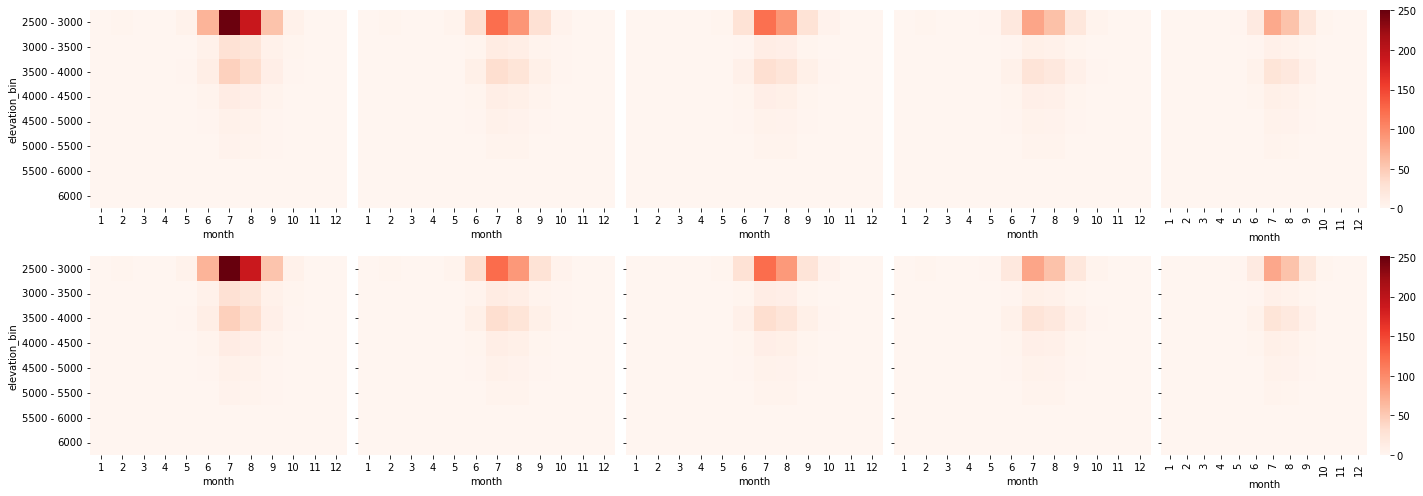

In [361]:
fig = plt.figure(figsize=(20, 7), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')


sns.heatmap(Q100_daily1, ax = mosaic['a'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily2, ax = mosaic['b'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily3, ax = mosaic['c'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily4, ax = mosaic['d'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily5, ax = mosaic['e'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)


sns.heatmap(Q100_once1, ax = mosaic['A'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once2, ax = mosaic['B'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once3, ax = mosaic['C'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once4, ax = mosaic['D'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once5, ax = mosaic['E'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)


mosaic['b'].set_ylabel('')
mosaic['b'].set_yticks([])

mosaic['c'].set_ylabel('')
mosaic['c'].set_yticks([])

mosaic['d'].set_ylabel('')
mosaic['d'].set_yticks([])
mosaic['e'].set_ylabel('')
mosaic['e'].set_yticks([])


for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_yticklabels([])
    mosaic[key].set_ylabel('')

In [362]:

percent = '60percent'

output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_{percent}/'
# output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_60percent/'


Q100_daily1_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily2_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily3_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily4_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily5_df = pd.read_csv(output_path + f'mustang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)

output_path1 = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percent}/'

Q100_once1_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once2_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once3_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once4_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once5_df = pd.read_csv(output_path1 + f'mustang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)


Q100_daily_mg1 = prepare_Q100_for_heatmap(Q100_daily1_df, 'month').dropna()
Q100_daily_mg2 = prepare_Q100_for_heatmap(Q100_daily2_df, 'month').dropna()
Q100_daily_mg3 = prepare_Q100_for_heatmap(Q100_daily3_df, 'month').dropna()
Q100_daily_mg4 = prepare_Q100_for_heatmap(Q100_daily4_df, 'month').dropna()
Q100_daily_mg5 = prepare_Q100_for_heatmap(Q100_daily5_df, 'month').dropna()

Q100_once_mg1 = prepare_Q100_for_heatmap(Q100_once1_df, 'month').dropna()
Q100_once_mg2 = prepare_Q100_for_heatmap(Q100_once2_df, 'month').dropna()
Q100_once_mg3 = prepare_Q100_for_heatmap(Q100_once3_df, 'month').dropna()
Q100_once_mg4 = prepare_Q100_for_heatmap(Q100_once4_df, 'month').dropna()
Q100_once_mg5 = prepare_Q100_for_heatmap(Q100_once5_df, 'month').dropna()



# # Compute global vmin and vmax across all datasets
vmin = min(df.min().min() for df in [Q100_daily_mg1, Q100_daily_mg2, Q100_daily_mg3, Q100_daily_mg4, Q100_daily_mg5, Q100_once_mg1, Q100_once_mg2, Q100_once_mg3, Q100_once_mg4, Q100_once_mg5])
vmax = max(df.max().max() for df in [Q100_daily_mg1, Q100_daily_mg2, Q100_daily_mg3, Q100_daily_mg4, Q100_daily_mg5, Q100_once_mg1, Q100_once_mg2, Q100_once_mg3, Q100_once_mg4, Q100_once_mg5])

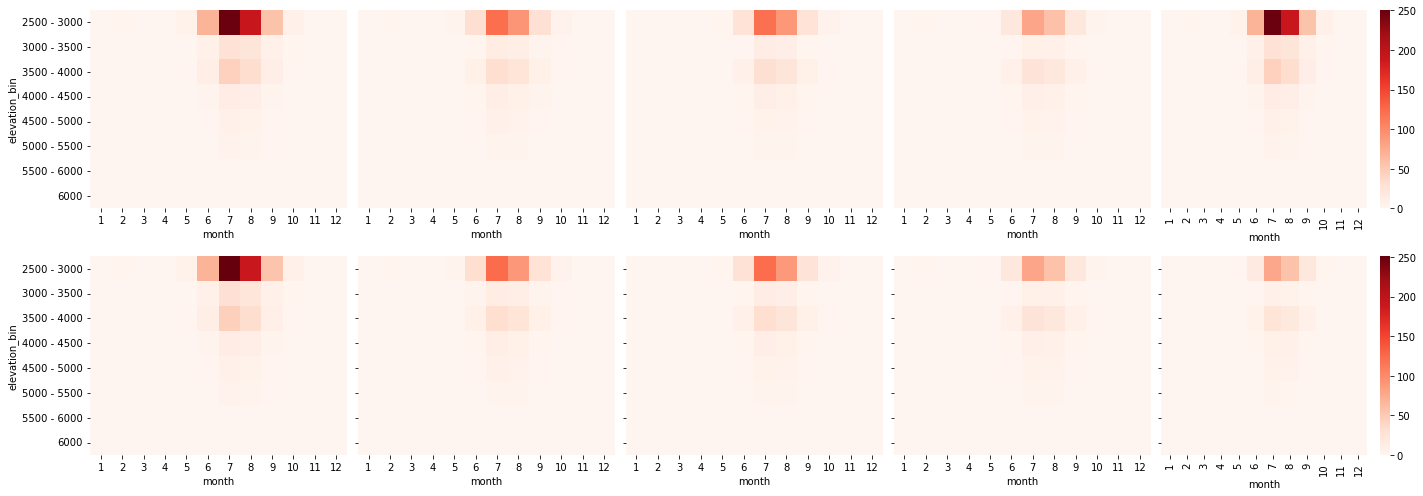

In [363]:
fig = plt.figure(figsize=(20, 7), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')


sns.heatmap(Q100_daily_mg1, ax = mosaic['a'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily_mg2, ax = mosaic['b'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily_mg3, ax = mosaic['c'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily_mg4, ax = mosaic['d'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_daily_mg5, ax = mosaic['e'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)


sns.heatmap(Q100_once_mg1, ax = mosaic['A'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once_mg2, ax = mosaic['B'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once_mg3, ax = mosaic['C'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once_mg4, ax = mosaic['D'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(Q100_once_mg5, ax = mosaic['E'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)


mosaic['b'].set_ylabel('')
mosaic['b'].set_yticks([])

mosaic['c'].set_ylabel('')
mosaic['c'].set_yticks([])

mosaic['d'].set_ylabel('')
mosaic['d'].set_yticks([])
mosaic['e'].set_ylabel('')
mosaic['e'].set_yticks([])


for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_yticklabels([])
    mosaic[key].set_ylabel('')

In [364]:
Q100_daily_mg4

month,1,2,3,4,5,6,7,8,9,10,11,12
elevation_bin,,,,,,,,,,,,
2500 - 3000,0.702501,2.009840,0.099326,0.000000,1.904611,18.781046,79.834333,58.089058,21.401093,3.870724,0.503043,0.724927
3000 - 3500,0.000000,0.087752,0.043455,0.000000,0.181883,1.643367,8.680292,6.835531,2.813148,0.649621,0.169607,0.000000
3500 - 4000,0.000000,0.000000,0.000000,0.008515,0.723425,6.194494,25.737776,19.490026,7.334515,1.313543,0.058170,0.000000
4000 - 4500,0.000000,0.000000,0.000000,0.000000,0.301948,2.180891,9.060567,6.988859,2.791720,0.273063,0.000000,0.000000
4500 - 5000,0.000000,0.000000,0.000000,0.000000,0.079929,1.015104,5.660944,4.391734,1.266184,0.014320,0.000000,0.000000
5000 - 5500,0.000000,0.000000,0.000000,0.000000,0.001994,0.567597,3.520062,2.965660,0.938314,0.006569,0.000000,0.000000
5500 - 6000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# count vs volume

In [365]:
def prepare_for_plot(dfcount, column, landcover):
    if column =='count':
        melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count') 
        melted = melted.rename(columns={'D_year': 'year', 'D_month': 'month'})
    if column == 'volume':
        melted = pd.melt(dfcount, id_vars=['year', 'month'], var_name='elevation', value_name='Q100')
    
    melted['elevation'] = melted['elevation'].astype(str).str.extract(r'^(\d+)')[0].astype(int)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    # melted = melted.sort_values('elevation_bin')
    melted['date_id'] = melted['year'].astype(str) + "_" + melted['month'].astype(str) + "_" + melted['elevation'].astype(str)
    melted = melted.sort_values('date_id')
    melted['landcover'] = landcover
    return melted 





In [366]:
# ----- DAILY input -------

# VOLUME 

percent = '60percent'

output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_{percent}/'

Q100_daily1_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily2_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily3_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily4_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily5_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)


Q100_daily1_melt = prepare_for_plot(Q100_daily1_df, 'volume', 'landcover 1')
Q100_daily2_melt = prepare_for_plot(Q100_daily2_df, 'volume', 'landcover 2')
Q100_daily3_melt = prepare_for_plot(Q100_daily3_df, 'volume', 'landcover 3')
Q100_daily4_melt = prepare_for_plot(Q100_daily4_df, 'volume', 'landcover 4')
Q100_daily5_melt = prepare_for_plot(Q100_daily5_df, 'volume', 'landcover 5')



# COUNT 
path_count = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_{percent}/'

dfcount_daily1_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover1.csv', index_col = 0).fillna(0)
dfcount_daily2_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover2.csv', index_col = 0).fillna(0)
dfcount_daily3_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover3.csv', index_col = 0).fillna(0)
dfcount_daily4_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover4.csv', index_col = 0).fillna(0)
dfcount_daily5_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover5.csv', index_col = 0).fillna(0)


dfcount_daily1_melt = prepare_for_plot(dfcount_daily1_df, 'count', 'landcover 1')
dfcount_daily2_melt = prepare_for_plot(dfcount_daily2_df, 'count', 'landcover 2')
dfcount_daily3_melt = prepare_for_plot(dfcount_daily3_df, 'count', 'landcover 3')
dfcount_daily4_melt = prepare_for_plot(dfcount_daily4_df, 'count', 'landcover 4')
dfcount_daily5_melt = prepare_for_plot(dfcount_daily5_df, 'count', 'landcover 5')


# ----- ONCE input -------

# VOLUME 

output_path1 = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percent}/'

Q100_once1_df = pd.read_csv(output_path1 + f'langtang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once2_df = pd.read_csv(output_path1 + f'langtang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once3_df = pd.read_csv(output_path1 + f'langtang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once4_df = pd.read_csv(output_path1 + f'langtang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once5_df = pd.read_csv(output_path1 + f'langtang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)



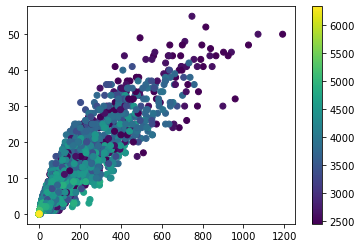

In [367]:
# df = df.merge(df_qstl, on = 'date_id')

daily1 = Q100_daily1_melt.merge(dfcount_daily1_melt, on = 'date_id')
daily2 = Q100_daily2_melt.merge(dfcount_daily2_melt, on = 'date_id')
daily3 = Q100_daily3_melt.merge(dfcount_daily3_melt, on = 'date_id')
daily4 = Q100_daily4_melt.merge(dfcount_daily4_melt, on = 'date_id')
daily5 = Q100_daily5_melt.merge(dfcount_daily5_melt, on = 'date_id')



plt.scatter(x = daily1.Q100, y =daily1.dfs_count, c = daily1.elevation_x)
plt.colorbar()

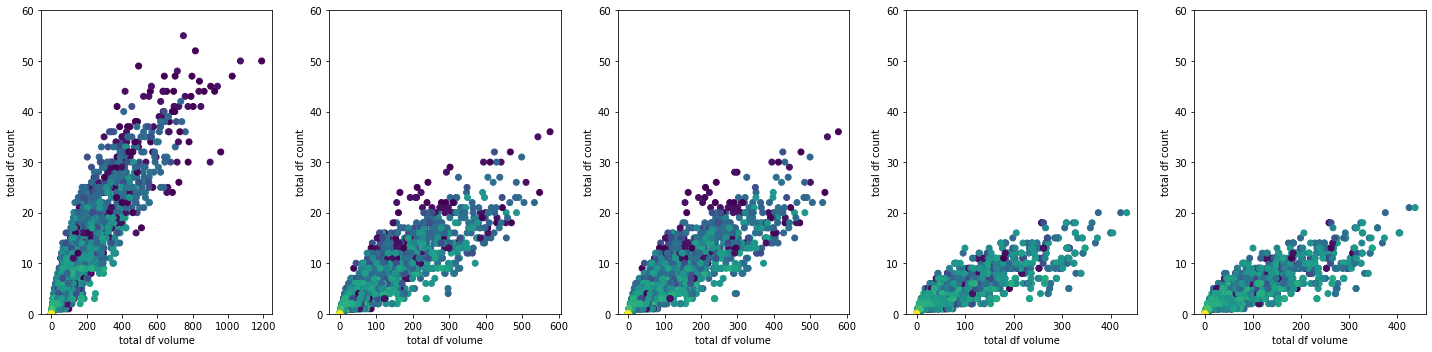

In [368]:

fig = plt.figure(figsize=(20, 5), layout='tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


mosaic['a'].scatter(x = daily1.Q100, y =daily1.dfs_count, c = daily1.elevation_x)
mosaic['b'].scatter(x = daily2.Q100, y =daily2.dfs_count, c = daily2.elevation_x)
mosaic['c'].scatter(x = daily3.Q100, y =daily3.dfs_count, c = daily3.elevation_x)
mosaic['d'].scatter(x = daily4.Q100, y =daily4.dfs_count, c = daily4.elevation_x)
mosaic['e'].scatter(x = daily5.Q100, y =daily5.dfs_count, c = daily5.elevation_x)






for key in ['a', 'b', 'c', 'd', 'e']:
    # mosaic[key].set_yticklabels([])
    mosaic[key].set_xlabel('total df volume')
    mosaic[key].set_ylabel('total df count')
    mosaic[key].set_ylim(0, daily1.dfs_count.max()+5)


In [369]:
# VOLUME 

# percent = '20percent'

output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percent}/'

Q100_once1_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once2_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once3_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once4_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once5_df = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Q100_{percent}_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)


Q100_once1_melt = prepare_for_plot(Q100_once1_df, 'volume', 'landcover 1')
Q100_once2_melt = prepare_for_plot(Q100_once2_df, 'volume', 'landcover 2')
Q100_once3_melt = prepare_for_plot(Q100_once3_df, 'volume', 'landcover 3')
Q100_once4_melt = prepare_for_plot(Q100_once4_df, 'volume', 'landcover 4')
Q100_once5_melt = prepare_for_plot(Q100_once5_df, 'volume', 'landcover 5')



# COUNT 
path_count = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percent}/'

dfcount_once1_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover1.csv', index_col = 0).fillna(0)
dfcount_once2_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover2.csv', index_col = 0).fillna(0)
dfcount_once3_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover3.csv', index_col = 0).fillna(0)
dfcount_once4_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover4.csv', index_col = 0).fillna(0)
dfcount_once5_df = pd.read_csv(path_count + f'langtang_monthly_dfs_count_{percent}_landcover5.csv', index_col = 0).fillna(0)


dfcount_once1_melt = prepare_for_plot(dfcount_once1_df, 'count', 'landcover 1')
dfcount_once2_melt = prepare_for_plot(dfcount_once2_df, 'count', 'landcover 2')
dfcount_once3_melt = prepare_for_plot(dfcount_once3_df, 'count', 'landcover 3')
dfcount_once4_melt = prepare_for_plot(dfcount_once4_df, 'count', 'landcover 4')
dfcount_once5_melt = prepare_for_plot(dfcount_once5_df, 'count', 'landcover 5')



In [370]:
once1 = Q100_once1_melt.merge(dfcount_once1_melt, on = 'date_id')
once2 = Q100_once2_melt.merge(dfcount_once2_melt, on = 'date_id')
once3 = Q100_once3_melt.merge(dfcount_once3_melt, on = 'date_id')
once4 = Q100_once4_melt.merge(dfcount_once4_melt, on = 'date_id')
once5 = Q100_once5_melt.merge(dfcount_once5_melt, on = 'date_id')




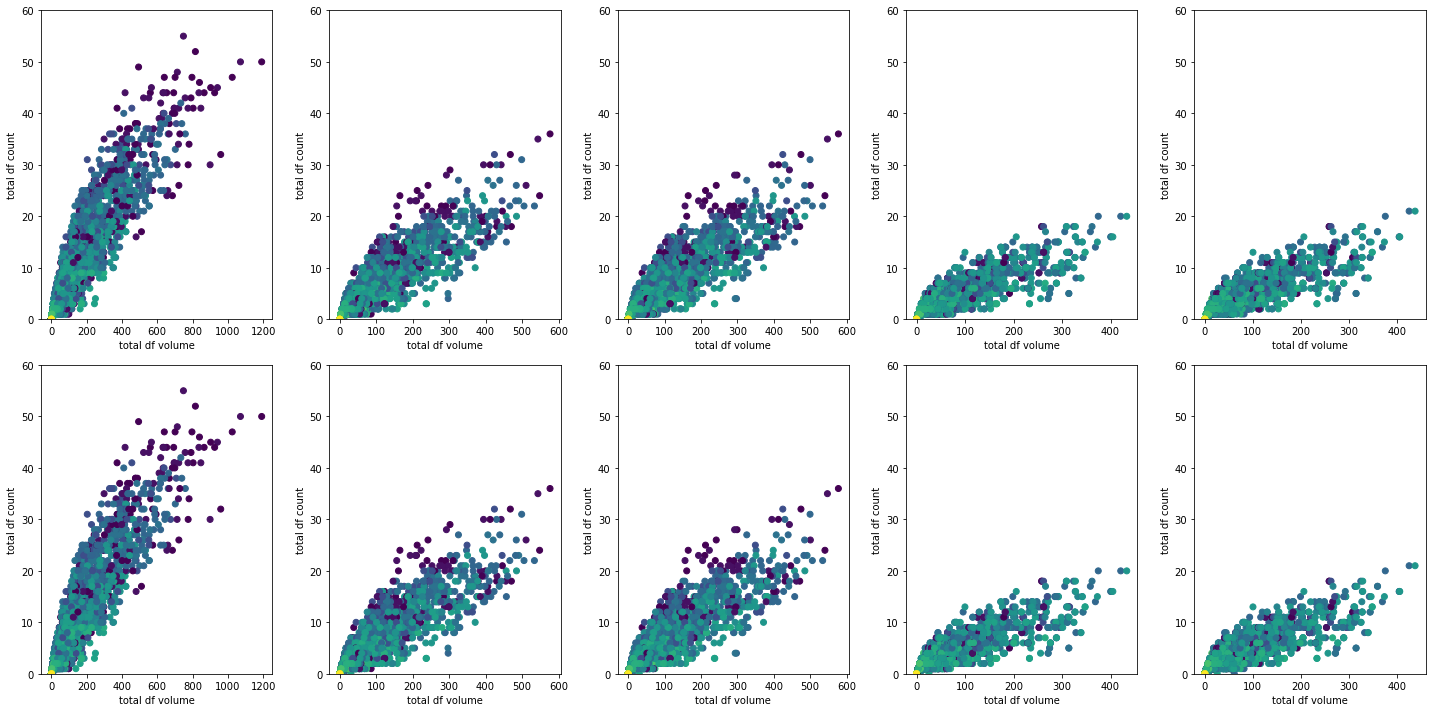

In [371]:

fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')


mosaic['a'].scatter(x = daily1.Q100, y =daily1.dfs_count, c = daily1.elevation_x)
mosaic['b'].scatter(x = daily2.Q100, y =daily2.dfs_count, c = daily2.elevation_x)
mosaic['c'].scatter(x = daily3.Q100, y =daily3.dfs_count, c = daily3.elevation_x)
mosaic['d'].scatter(x = daily4.Q100, y =daily4.dfs_count, c = daily4.elevation_x)
mosaic['e'].scatter(x = daily5.Q100, y =daily5.dfs_count, c = daily5.elevation_x)


mosaic['A'].scatter(x = once1.Q100, y =once1.dfs_count, c = once1.elevation_x)
mosaic['B'].scatter(x = once2.Q100, y =once2.dfs_count, c = once2.elevation_x)
mosaic['C'].scatter(x = once3.Q100, y =once3.dfs_count, c = once3.elevation_x)
mosaic['D'].scatter(x = once4.Q100, y =once4.dfs_count, c = once4.elevation_x)
mosaic['E'].scatter(x = once5.Q100, y =once5.dfs_count, c = once5.elevation_x)





for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    # mosaic[key].set_yticklabels([])
    mosaic[key].set_xlabel('total df volume')
    mosaic[key].set_ylabel('total df count')
    mosaic[key].set_ylim(0, daily1.dfs_count.max()+5)


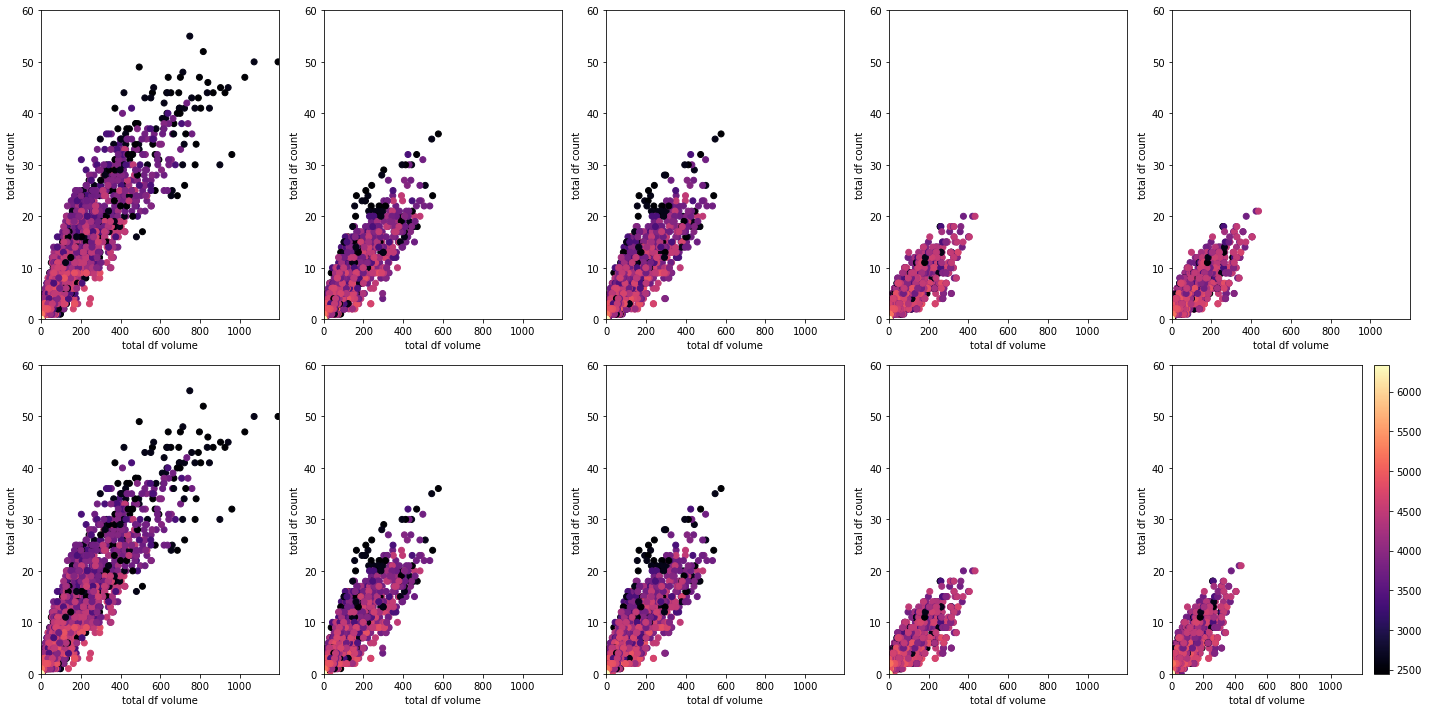

In [372]:


# daily1 = daily1[(daily1['elevation_bin'] != '5500-6000') & (daily1['elevation_bin'] != '6000')]
# daily2 = daily2[(daily2['elevation_bin'] != '5500-6000') & (daily2['elevation_bin'] != '6000')]
# daily3 = daily3[(daily3['elevation_bin'] != '5500-6000') & (daily3['elevation_bin'] != '6000')]
# daily4 = daily4[(daily4['elevation_bin'] != '5500-6000') & (daily4['elevation_bin'] != '6000')]
# daily5 = daily5[(daily5['elevation_bin'] != '5500-6000') & (daily5['elevation_bin'] != '6000')]


# once1 = once1[(once1['elevation_bin'] != '5500-6000') & (once1['elevation_bin'] != '6000')].copy()
# once2 = once2[(once2['elevation_bin'] != '5500-6000') & (once2['elevation_bin'] != '6000')]
# once3 = once3[(once3['elevation_bin'] != '5500-6000') & (once3['elevation_bin'] != '6000')]
# once4 = once4[(once4['elevation_bin'] != '5500-6000') & (once4['elevation_bin'] != '6000')]
# once5 = once4[(once5['elevation_bin'] != '5500-6000') & (once5['elevation_bin'] != '6000')]






fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')

cmap = 'magma'
mosaic['a'].scatter(x = daily1.Q100, y =daily1.dfs_count, c = daily1.elevation_x, cmap = cmap)
mosaic['b'].scatter(x = daily2.Q100, y =daily2.dfs_count, c = daily2.elevation_x, cmap = cmap)
mosaic['c'].scatter(x = daily3.Q100, y =daily3.dfs_count, c = daily3.elevation_x, cmap = cmap)
mosaic['d'].scatter(x = daily4.Q100, y =daily4.dfs_count, c = daily4.elevation_x, cmap = cmap)
mosaic['e'].scatter(x = daily5.Q100, y =daily5.dfs_count, c = daily5.elevation_x, cmap = cmap)


mosaic['A'].scatter(x = once1.Q100,    y =once1.dfs_count, c = once1.elevation_x, cmap = cmap)
mosaic['B'].scatter(x = once2.Q100,    y =once2.dfs_count, c = once2.elevation_x, cmap = cmap)
mosaic['C'].scatter(x = once3.Q100,    y =once3.dfs_count, c = once3.elevation_x, cmap = cmap)
mosaic['D'].scatter(x = once4.Q100,    y =once4.dfs_count, c = once4.elevation_x, cmap = cmap)
sc=mosaic['E'].scatter(x = once5.Q100, y =once5.dfs_count, c = once5.elevation_x, cmap = cmap)


cbar = fig.colorbar(sc, ax=mosaic['E'])



for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    # mosaic[key].set_yticklabels([])
    mosaic[key].set_xlabel('total df volume')
    mosaic[key].set_ylabel('total df count')
    mosaic[key].set_ylim(0, daily1.dfs_count.max()+5)
    mosaic[key].set_xlim(0, once1.Q100.max()+5)

# plt.savefig(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/count_vs_volume_per_elevation_{percent}.png', bbox_layout = 'tight', dpi = 300)

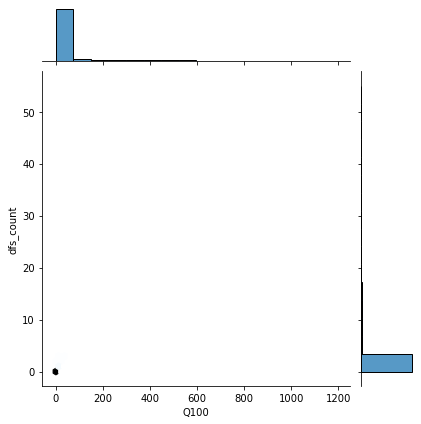

In [373]:
sns.jointplot(data = daily1, x = 'Q100', y ='dfs_count', kind = 'hex')


# percent

In [374]:
output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/'

Qstl1 = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/langtang_monthly_sum_elevation_Qstl_1landcover_mm.csv',index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Qstl1 = prepare_for_plot(Qstl1, 'volume', 'landcover 1').rename(columns  ={ 'Q100' :'Qstl'})



# ------ ONCE 

Q100_once1_20 = pd.read_csv(output_path + f'output_20percent/langtang_monthly_sum_elevation_Q100_20percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once1_30 = pd.read_csv(output_path + f'output_30percent/langtang_monthly_sum_elevation_Q100_30percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once1_40 = pd.read_csv(output_path + f'output_40percent/langtang_monthly_sum_elevation_Q100_40percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once1_50 = pd.read_csv(output_path + f'output_50percent/langtang_monthly_sum_elevation_Q100_50percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_once1_60 = pd.read_csv(output_path + f'output_60percent/langtang_monthly_sum_elevation_Q100_60percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)


once1_20 = prepare_for_plot(Q100_once1_20, 'volume', 'landcover 1')[['Q100', 'date_id']]
once1_30 = prepare_for_plot(Q100_once1_30, 'volume', 'landcover 1')[['Q100', 'date_id']]
once1_40 = prepare_for_plot(Q100_once1_40, 'volume', 'landcover 1')[['Q100', 'date_id']]
once1_50 = prepare_for_plot(Q100_once1_50, 'volume', 'landcover 1')[['Q100', 'date_id']]
once1_60 = prepare_for_plot(Q100_once1_60, 'volume', 'landcover 1')[['Q100', 'date_id']]


# ------ DAILY 
output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/'

Q100_daily1_20 = pd.read_csv(output_path + f'output_20percent/langtang_monthly_sum_elevation_Q100_20percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily1_30 = pd.read_csv(output_path + f'output_30percent/langtang_monthly_sum_elevation_Q100_30percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily1_40 = pd.read_csv(output_path + f'output_40percent/langtang_monthly_sum_elevation_Q100_40percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily1_50 = pd.read_csv(output_path + f'output_50percent/langtang_monthly_sum_elevation_Q100_50percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
Q100_daily1_60 = pd.read_csv(output_path + f'output_60percent/langtang_monthly_sum_elevation_Q100_60percent_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)


daily1_20 = prepare_for_plot(Q100_daily1_20, 'volume', 'landcover 1')[['Q100', 'date_id']]
daily1_30 = prepare_for_plot(Q100_daily1_30, 'volume', 'landcover 1')[['Q100', 'date_id']]
daily1_40 = prepare_for_plot(Q100_daily1_40, 'volume', 'landcover 1')[['Q100', 'date_id']]
daily1_50 = prepare_for_plot(Q100_daily1_50, 'volume', 'landcover 1')[['Q100', 'date_id']]
daily1_60 = prepare_for_plot(Q100_daily1_60, 'volume', 'landcover 1')[['Q100', 'date_id']]






In [375]:
# test20 = test20.merge(testQstl1, on = 'date_id')

In [376]:
def calculate_percent(df, df_qstl):
    
    df = df.merge(df_qstl, on = 'date_id')
    df['Q100_percent'] = ((df.Q100 * 100)/df.Qstl).fillna(0)
    # df.Q100_percent 
    return df

once1_20 = calculate_percent(once1_20, Qstl1)#.replace(0, np.nan)
once1_30 = calculate_percent(once1_30, Qstl1)#.replace(0, np.nan)
once1_40 = calculate_percent(once1_40, Qstl1)#.replace(0, np.nan)
once1_50 = calculate_percent(once1_50, Qstl1)#.replace(0, np.nan)
once1_60 = calculate_percent(once1_60, Qstl1)#.replace(0, np.nan)


daily1_20 = calculate_percent(daily1_20, Qstl1)#.replace(0, np.nan)
daily1_30 = calculate_percent(daily1_30, Qstl1)#.replace(0, np.nan)
daily1_40 = calculate_percent(daily1_40, Qstl1)#.replace(0, np.nan)
daily1_50 = calculate_percent(daily1_50, Qstl1)#.replace(0, np.nan)
daily1_60 = calculate_percent(daily1_60, Qstl1)#.replace(0, np.nan)


In [377]:
daily1_20

,Q100,date_id,year,month,elevation,Qstl,elevation_bin,landcover,Q100_percent
0,0.0,1989_10_2448,1989,10,2448,0.0,2500,landcover 1,0.0
1,0.0,1989_10_2613,1989,10,2613,0.0,2500 - 3000,landcover 1,0.0
2,0.0,1989_10_3360,1989,10,3360,0.0,3000 - 3500,landcover 1,0.0
3,0.0,1989_10_3421,1989,10,3421,0.0,3000 - 3500,landcover 1,0.0
4,0.0,1989_10_3695,1989,10,3695,0.0,3500 - 4000,landcover 1,0.0
...,...,...,...,...,...,...,...,...,...
20639,0.0,2022_9_5763,2022,9,5763,0.0,5500 - 6000,landcover 1,0.0
20640,0.0,2022_9_5859,2022,9,5859,0.0,5500 - 6000,landcover 1,0.0
20641,0.0,2022_9_5870,2022,9,5870,0.0,5500 - 6000,landcover 1,0.0
20642,0.0,2022_9_5936,2022,9,5936,0.0,5500 - 6000,landcover 1,0.0


In [378]:
# once1_60.Q100.plot()
# once1_20.Q100.plot()

Text(0.5, 1.0, '60 percent')

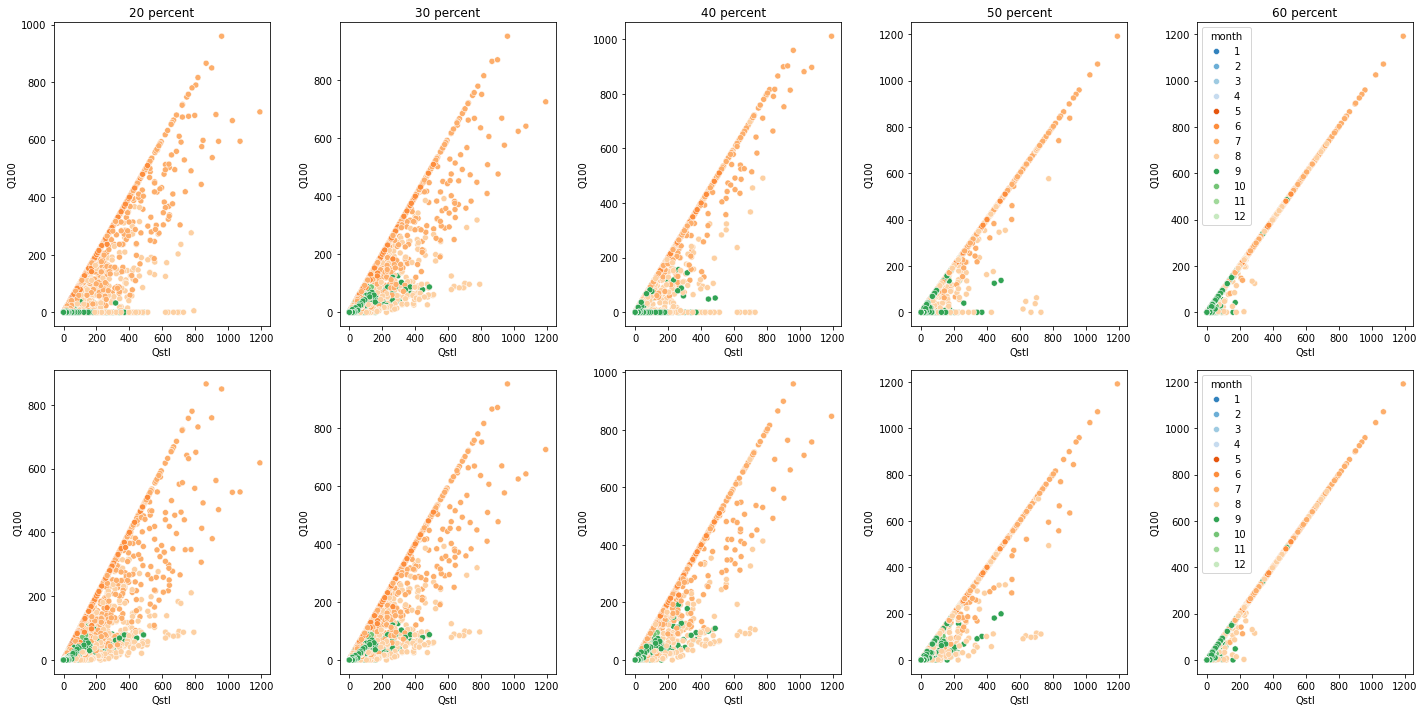

In [379]:
fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')

palette = 'tab20c'

sns.scatterplot(data = once1_20, x = 'Qstl', y = 'Q100', ax = mosaic['a'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
sns.scatterplot(data = once1_30, x = 'Qstl', y = 'Q100', ax = mosaic['b'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
sns.scatterplot(data = once1_40, x = 'Qstl', y = 'Q100', ax = mosaic['c'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
sns.scatterplot(data = once1_50, x = 'Qstl', y = 'Q100', ax = mosaic['d'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
sns.scatterplot(data = once1_60, x = 'Qstl', y = 'Q100', ax = mosaic['e'], legend = True, hue = 'month',  palette = palette)#, orient = 'h')


sns.scatterplot(data = daily1_20, x = 'Qstl', y = 'Q100', ax = mosaic['A'], legend = False, hue = 'month', palette = palette)
sns.scatterplot(data = daily1_30, x = 'Qstl', y = 'Q100', ax = mosaic['B'], legend = False, hue = 'month', palette = palette)
sns.scatterplot(data = daily1_40, x = 'Qstl', y = 'Q100', ax = mosaic['C'], legend = False, hue = 'month', palette = palette)
sns.scatterplot(data = daily1_50, x = 'Qstl', y = 'Q100', ax = mosaic['D'], legend = False, hue = 'month', palette = palette)
sns.scatterplot(data = daily1_60, x = 'Qstl', y = 'Q100', ax = mosaic['E'], legend = True, hue = 'month',  palette = palette)

mosaic['a'].set_title('20 percent')
mosaic['b'].set_title('30 percent')
mosaic['c'].set_title('40 percent')
mosaic['d'].set_title('50 percent')
mosaic['e'].set_title('60 percent')


# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/Qstl_vs_Qs_landcover1.png', bbox_inches = 'tight', dpi = 300)

Text(0.5, 1.0, '60 percent')

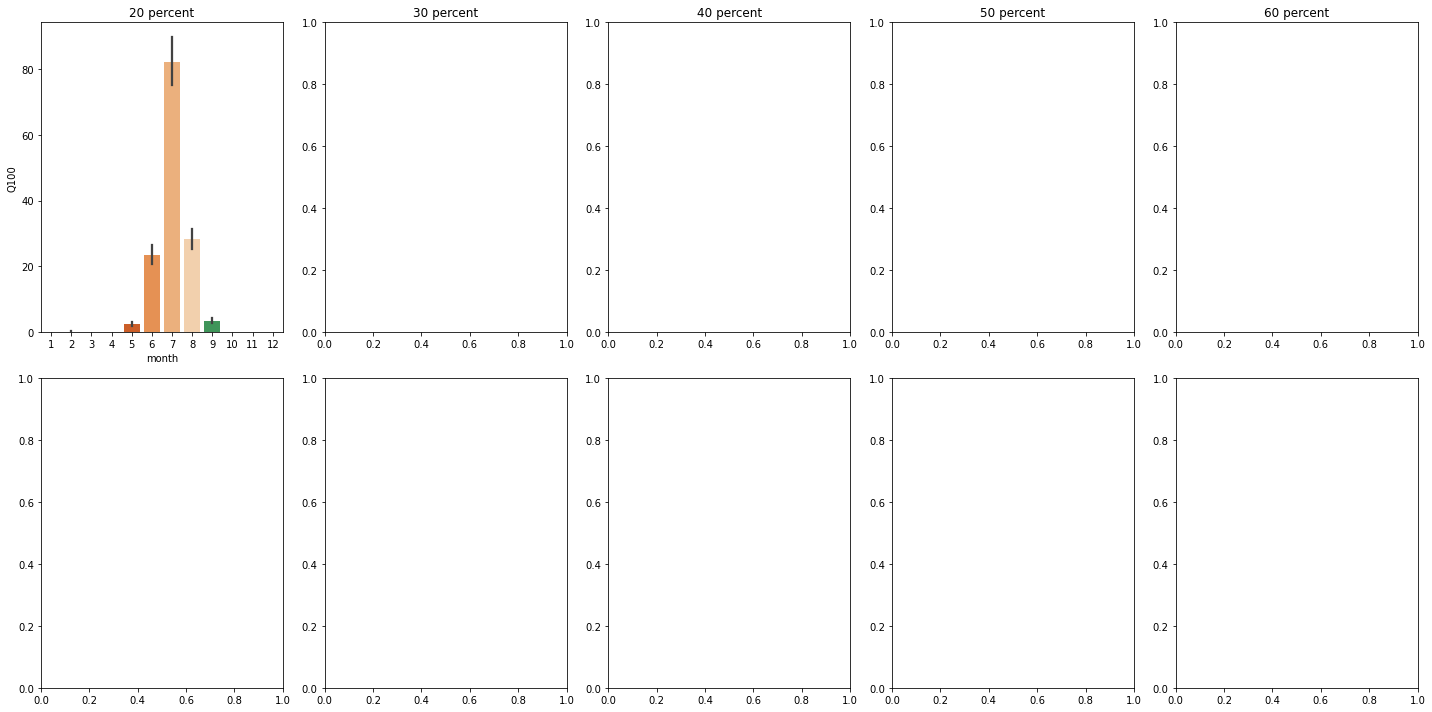

In [380]:
fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')

palette = 'tab20c'

sns.barplot(data = once1_20, x = 'month', y = 'Q100', ax = mosaic['a'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
# sns.scatterplot(data = once1_30, x = 'Qstl', y = 'Q100', ax = mosaic['b'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
# sns.scatterplot(data = once1_40, x = 'Qstl', y = 'Q100', ax = mosaic['c'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
# sns.scatterplot(data = once1_50, x = 'Qstl', y = 'Q100', ax = mosaic['d'], legend = False, hue = 'month', palette = palette)#, orient = 'h')
# sns.scatterplot(data = once1_60, x = 'Qstl', y = 'Q100', ax = mosaic['e'], legend = True, hue = 'month',  palette = palette)#, orient = 'h')


# sns.scatterplot(data = daily1_20, x = 'Qstl', y = 'Q100', ax = mosaic['A'], legend = False, hue = 'month', palette = palette)
# sns.scatterplot(data = daily1_30, x = 'Qstl', y = 'Q100', ax = mosaic['B'], legend = False, hue = 'month', palette = palette)
# sns.scatterplot(data = daily1_40, x = 'Qstl', y = 'Q100', ax = mosaic['C'], legend = False, hue = 'month', palette = palette)
# sns.scatterplot(data = daily1_50, x = 'Qstl', y = 'Q100', ax = mosaic['D'], legend = False, hue = 'month', palette = palette)
# sns.scatterplot(data = daily1_60, x = 'Qstl', y = 'Q100', ax = mosaic['E'], legend = True, hue = 'month',  palette = palette)

mosaic['a'].set_title('20 percent')
mosaic['b'].set_title('30 percent')
mosaic['c'].set_title('40 percent')
mosaic['d'].set_title('50 percent')
mosaic['e'].set_title('60 percent')





# try plotting the spread or distribution or boxes above it
# or also plot somehow box plots that can communicate sediment limitations

<Figure size 1440x720 with 0 Axes>

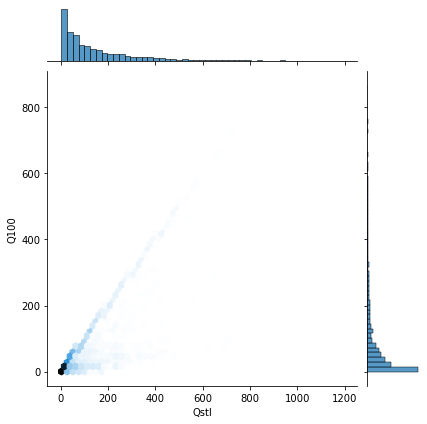

In [291]:
fig = plt.figure(figsize=(20, 10), layout='tight')

sns.jointplot(data = daily1_20, x = 'Qstl', y = 'Q100', kind = 'hex')#, ax = mosaic['a'])#, legend = False, hue = 'month', palette = 'Set1')#, orient = 'h')

<AxesSubplot:label='e', xlabel='month', ylabel='Q100_percent'>

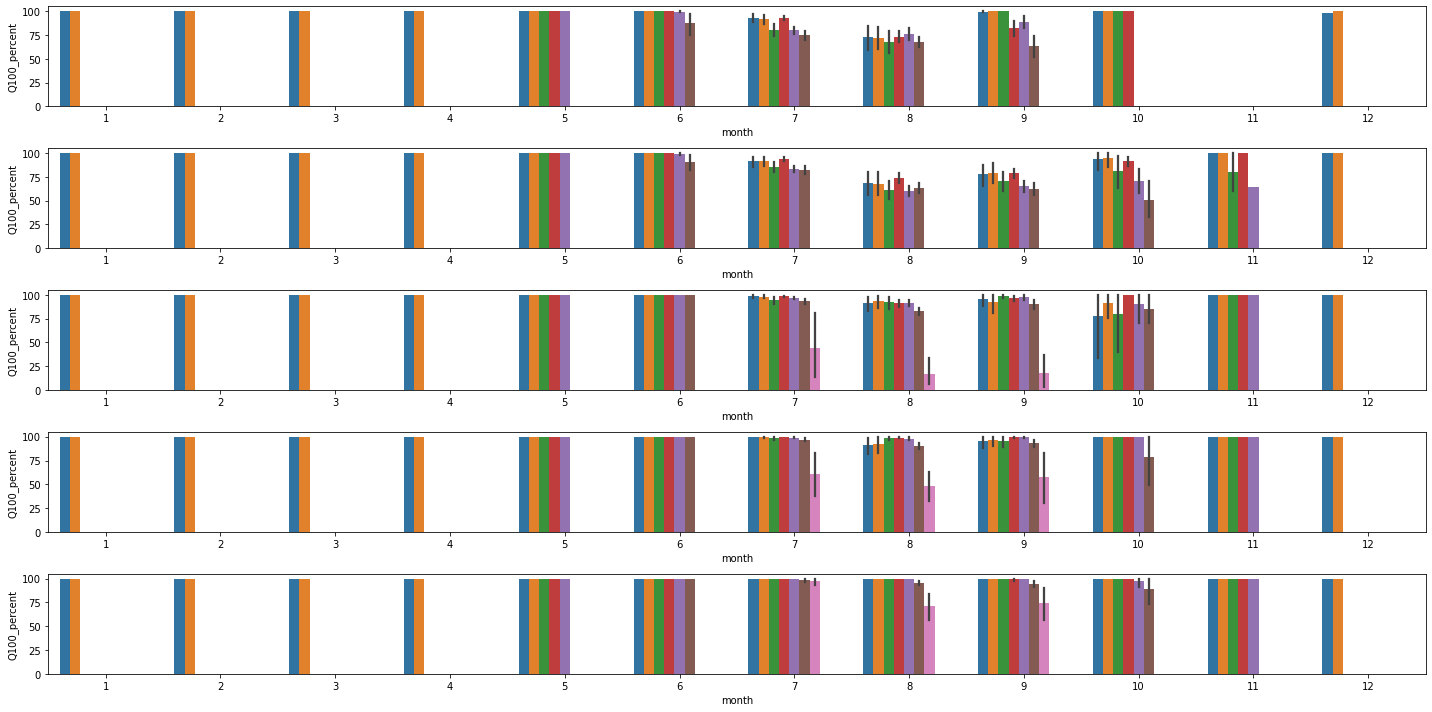

In [279]:
fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            a
                            b
                            c
                            d
                            e
                            ''')

sns.barplot(data = once1_20, x = 'month', y = 'Q100_percent', ax = mosaic['a'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = once1_30, x = 'month', y = 'Q100_percent', ax = mosaic['b'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = once1_40, x = 'month', y = 'Q100_percent', ax = mosaic['c'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = once1_50, x = 'month', y = 'Q100_percent', ax = mosaic['d'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = once1_60, x = 'month', y = 'Q100_percent', ax = mosaic['e'], legend = False, hue = 'elevation_bin')#, orient = 'h')

<AxesSubplot:label='e', xlabel='month', ylabel='Q100_percent'>

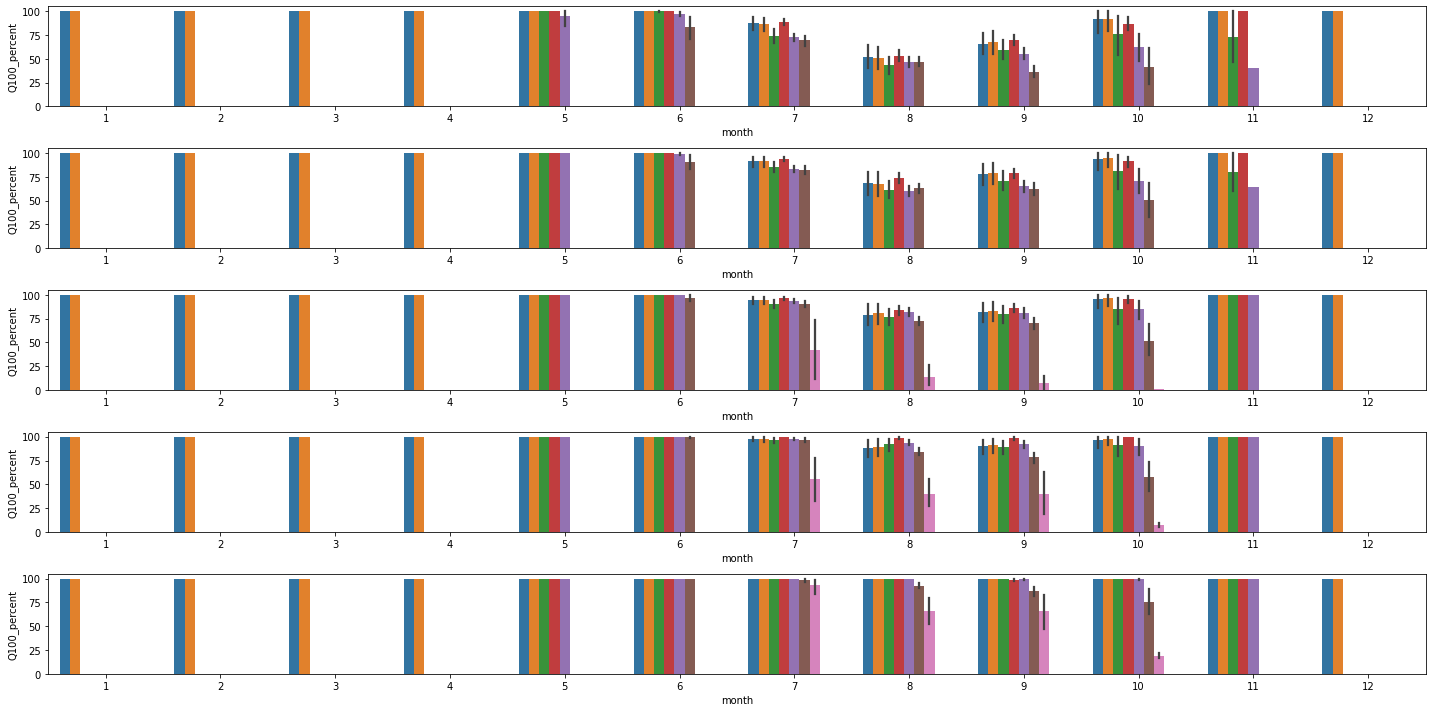

In [281]:
fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            a
                            b
                            c
                            d
                            e
                            ''')

sns.barplot(data = daily1_20, x = 'month', y = 'Q100_percent', ax = mosaic['a'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = daily1_30, x = 'month', y = 'Q100_percent', ax = mosaic['b'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = daily1_40, x = 'month', y = 'Q100_percent', ax = mosaic['c'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = daily1_50, x = 'month', y = 'Q100_percent', ax = mosaic['d'], legend = False, hue = 'elevation_bin')#, orient = 'h')
sns.barplot(data = daily1_60, x = 'month', y = 'Q100_percent', ax = mosaic['e'], legend = False, hue = 'elevation_bin')#, orient = 'h')

<AxesSubplot:label='e', xlabel='month', ylabel='Q100'>

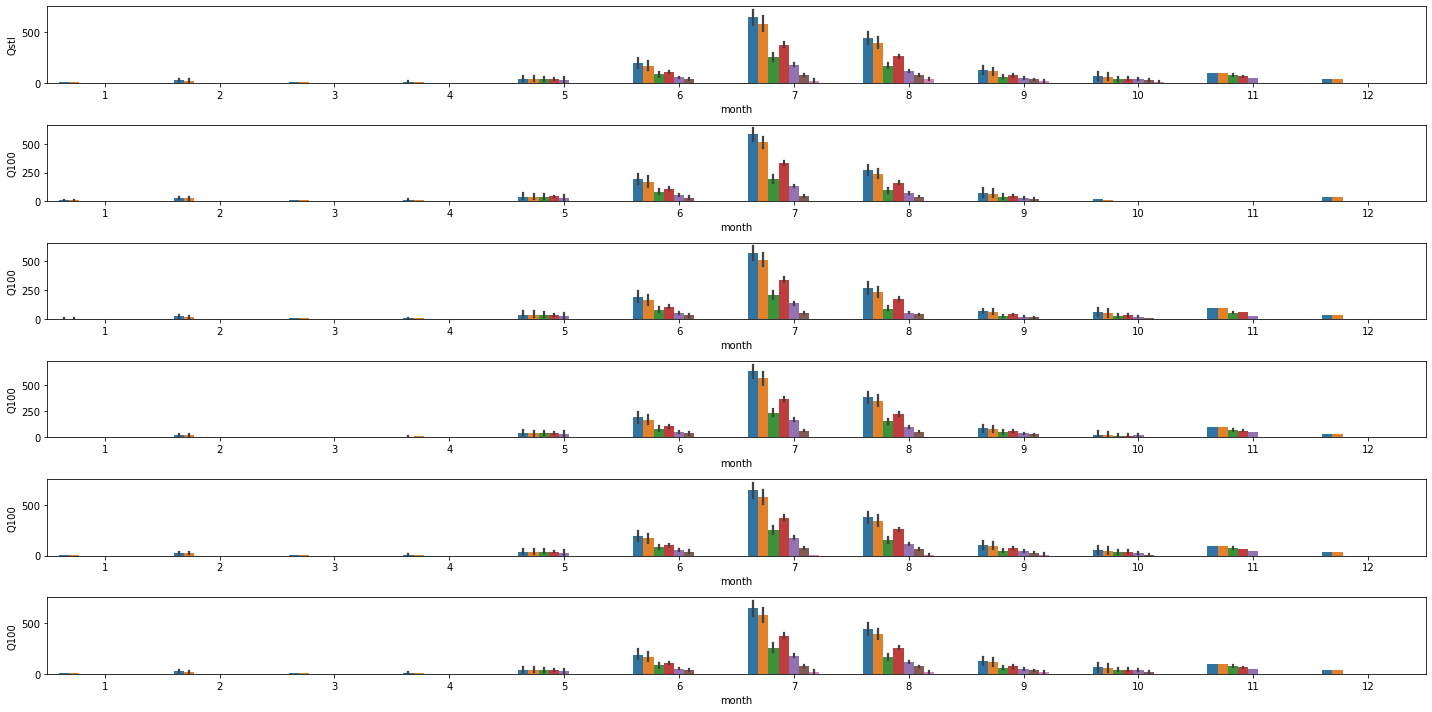

In [280]:
fig = plt.figure(figsize=(20, 10), layout='tight')

mosaic = fig.subplot_mosaic('''
                            f
                            a
                            b
                            c
                            d
                            e
                            ''')

sns.barplot(data = once1_20, x = 'month', y = 'Qstl', hue = 'elevation_bin', ax = mosaic['f'], legend = False)
sns.barplot(data = once1_20, x = 'month', y = 'Q100', hue = 'elevation_bin', ax = mosaic['a'], legend = False)
sns.barplot(data = once1_30, x = 'month', y = 'Q100', hue = 'elevation_bin', ax = mosaic['b'], legend = False)
sns.barplot(data = once1_40, x = 'month', y = 'Q100', hue = 'elevation_bin', ax = mosaic['c'], legend = False)
sns.barplot(data = once1_50, x = 'month', y = 'Q100', hue = 'elevation_bin', ax = mosaic['d'], legend = False)
sns.barplot(data = once1_60, x = 'month', y = 'Q100', hue = 'elevation_bin', ax = mosaic['e'], legend = False)

<AxesSubplot:label='a', xlabel='month', ylabel='Q100_percent'>

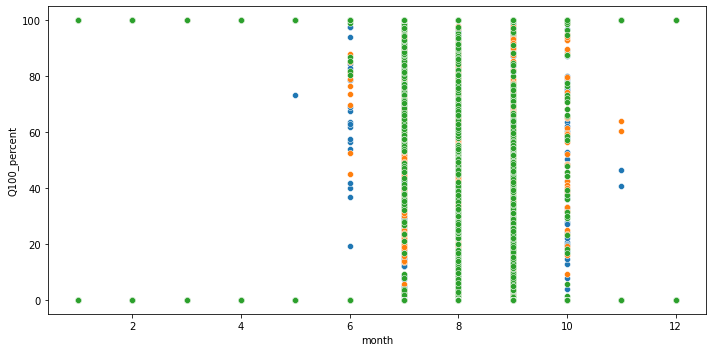

In [155]:
fig = plt.figure(figsize=(10, 5), layout='tight')

mosaic = fig.subplot_mosaic('''
                            a

                            ''')

sns.scatterplot(data = test20, x = 'month', y = 'Q100_percent', ax = mosaic['a'], legend = True)
sns.scatterplot(data = test30, x = 'month', y = 'Q100_percent', ax = mosaic['a'], legend = False)
sns.scatterplot(data = test40, x = 'month', y = 'Q100_percent', ax = mosaic['a'], legend = False)

# plt.legend()

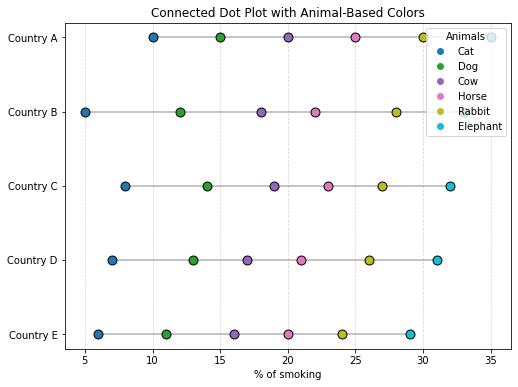

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Sample data: Each country has values for 6 animals
categories = ["Country A", "Country B", "Country C", "Country D", "Country E"]
animals = ["Cat", "Dog", "Cow", "Horse", "Rabbit", "Elephant"]
values = [
    [10, 15, 20, 25, 30, 35],  # Country A
    [5, 12, 18, 22, 28, 33],   # Country B
    [8, 14, 19, 23, 27, 32],   # Country C
    [7, 13, 17, 21, 26, 31],   # Country D
    [6, 11, 16, 20, 24, 29]    # Country E
]

# Reverse categories for proper alignment
categories = categories[::-1]
values = values[::-1]

# Assign a unique color to each animal
cmap = cm.get_cmap("tab10", len(animals))  # 'tab10' provides distinct colors
animal_colors = {animal: cmap(i) for i, animal in enumerate(animals)}

plt.figure(figsize=(8, 6))

# Loop through categories and plot values, coloring each dot by animal
for i, (cat, vals) in enumerate(zip(categories, values)):
    for j, v in enumerate(vals):
        plt.scatter(v, i, color=animal_colors[animals[j]], edgecolor="k", s=80, zorder=3, label=animals[j] if i == 0 else None)

    # Connect dots with a gray line
    plt.plot(vals, [i] * len(vals), color="gray", alpha=0.6, zorder=2)

# Formatting
plt.yticks(range(len(categories)), categories)
plt.xlabel("% of smoking")
plt.title("Connected Dot Plot with Animal-Based Colors")
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Add a legend for animals (only one label per animal)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=animal_colors[animal], markersize=8) for animal in animals]
plt.legend(handles, animals, title="Animals", loc="upper right")

plt.show()


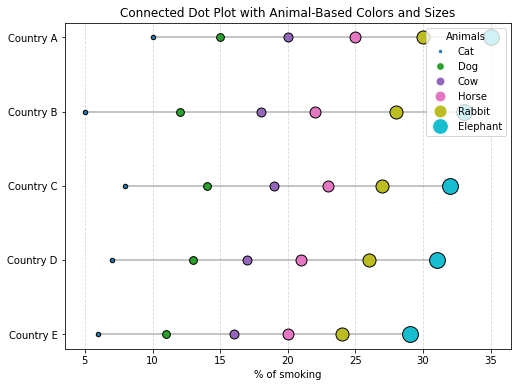

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Sample data: Each country has values for 6 animals
categories = ["Country A", "Country B", "Country C", "Country D", "Country E"]
animals = ["Cat", "Dog", "Cow", "Horse", "Rabbit", "Elephant"]
values = [
    [10, 15, 20, 25, 30, 35],  # Country A
    [5, 12, 18, 22, 28, 33],   # Country B
    [8, 14, 19, 23, 27, 32],   # Country C
    [7, 13, 17, 21, 26, 31],   # Country D
    [6, 11, 16, 20, 24, 29]    # Country E
]

# Reverse categories for proper alignment
categories = categories[::-1]
values = values[::-1]

# Assign a unique color to each animal
cmap = cm.get_cmap("tab10", len(animals))  # 'tab10' provides distinct colors
animal_colors = {animal: cmap(i) for i, animal in enumerate(animals)}

# Assign a unique size per animal (adjust these values as needed)
animal_sizes = {
    "Cat": 20,
    "Dog": 60,
    "Cow": 80,
    "Horse": 120,
    "Rabbit": 170,
    "Elephant": 250
}

plt.figure(figsize=(8, 6))

# Loop through categories and plot values, coloring each dot by animal and scaling by size
for i, (cat, vals) in enumerate(zip(categories, values)):
    for j, v in enumerate(vals):
        plt.scatter(v, i, color=animal_colors[animals[j]], edgecolor="k",
                    s=animal_sizes[animals[j]], zorder=3, label=animals[j] if i == 0 else None)

    # Connect dots with a gray line
    plt.plot(vals, [i] * len(vals), color="gray", alpha=0.6, zorder=2)

# Formatting
plt.yticks(range(len(categories)), categories)
plt.xlabel("% of smoking")
plt.title("Connected Dot Plot with Animal-Based Colors and Sizes")
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Add a legend for animals (one label per animal)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=animal_colors[animal],
                       markersize=np.sqrt(animal_sizes[animal])) for animal in animals]
plt.legend(handles, animals, title="Animals", loc="upper right")

plt.show()
